## Example usage

Assuming that the LogicCircuits Julia package has been installed with `julia -e 'using Pkg; Pkg.add("LogicCircuits")'`, we can start using it as follows.

In [1]:
using LogicCircuits

### Reasoning with manually constructed circuits

We begin by creating three positive literals (logical variables) and manually constructing a simple circuit using logical connectives & (and), | (or), and - (not).

In [2]:
sun, rain, rainbow = pos_literals(LogicCircuit, 3)
circuit = (rainbow & sun & rain) | (-rainbow); # rainbow implies sun and rain

Just like any logical circuit or Boolean function, we can evaluate ours on various inputs.

In [3]:
circuit(false, true, true) # sun is false, rain is true, rainbow is true

false

In [4]:
circuit(true, true, true) # sun is true, rain is true, rainbow is true

true

The purpose of this package, however, is to enable more interesting inference scenarios. This is possible by ensuring that the circuit has certain [properties](https://juice-jl.github.io/LogicCircuits.jl/dev/manual/properties/), such as *decomposability*, *determinism*, and more.
Our current circuit happens to already be decomposable and deterministic by construction:

In [5]:
isdecomposable(circuit) && isdeterministic(circuit)

true

The decomposability property ensures that we can ask whether the circuit is satisfiable (the classical SAT problem) and, surprisingly, still get our answer efficiently. Of course, from the input `true, true, true` tried above, we know the answer to be true.

In [6]:
issatisfiable(circuit) # does there exist an input that outputs true?

true

In addition, the determinism property allows us to efficiently decide whether the circuit is a tautology (always true), or compute its model count, that is, the number of satisfying assignments.

In [7]:
istautology(circuit) # do all inputs give the circuit output true?

false

In [8]:
model_count(circuit) # how many possible inputs give the output true?

5

### Reasoning with compiled circuits

As logical sentences become more complicated, it becomes infeasible to manually write down circuits that have the requisite properties that guarantee tractable inference.

A process called *compilation* can solve this problem. Concretely, `LogicCircuits` supports compilation into a particular type of circuit called SDD. We construct an SDD manager with four additional variables, and then ask to compile our running example circuit into an SDD:

In [9]:
manager = SddMgr(7, :balanced)
circuit = compile(manager, circuit);

Now we are able to incorporate many more logical sentences into the same circuit.

In [10]:
sun, rain, rainbow, cloud, snow, los_angeles, belgium = pos_literals(Sdd, manager, 7)
circuit &= (-los_angeles | -belgium) # cannot be in LA and Belgium at the same time
circuit &= (los_angeles ⇒ sun) ∧ (belgium ⇒ cloud) # unicode logical syntax
circuit &= (¬(rain ∨ snow) ⇐ ¬cloud); # no rain or snow without clouds

Incorporating these constraints has increased the size of our circuit, but crucially, the circuit is still decomposable and deterministic.

In [11]:
"Our circuit has $(num_nodes(circuit)) nodes and $(num_edges(circuit)) edges"

"Our circuit has 71 nodes and 117 edges"

The circuit looks as follows.

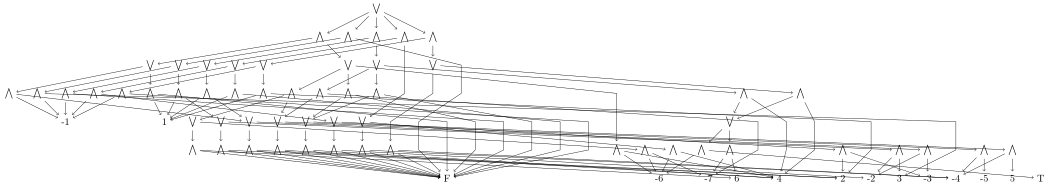

In [12]:
plot(circuit)

In [13]:
isdecomposable(circuit) && isdeterministic(circuit)

true

This means that we can still decide satisfiability, count models, and solve various inference tasks efficiently. For example, we can compute the fraction of inputs that gives the output true:

In [14]:
sat_prob(circuit)

29//128

Moreover, compiled SDD circuits allow for efficiently checking whether one circuit logically entails another circuit, and whether two circuits are logically equivalent.

In [15]:
entails(circuit, (rainbow ⇒ cloud))

true

In [16]:
entails(circuit, (rainbow ⇒ belgium))

false

In [17]:
equivalent((rainbow ⇒ belgium), (¬belgium ⇒ ¬rainbow))

true

Logical constraints are often written in conjunctive normal form (CNF). These can be loaded from file and compiled into circuits, using an SDD manager whose decomposition structure is specified by a *vtree* file.

In [18]:
manager = SddMgr(zoo_vtree("iscas89/s208.1.scan.min.vtree"))
circuit = compile(manager, zoo_cnf("iscas89/s208.1.scan.cnf")) # CNF has 285 clauses
"This CNF has $(model_count(circuit)) satisfying assignments. Its circuit has $(num_nodes(circuit)) nodes and $(num_edges(circuit)) edges."

"This CNF has 262144 satisfying assignments. Its circuit has 3115 nodes and 5826 edges."

### Advanced functionality

`LogicCircuits` further provides
 * CPU (SIMD) and GPU (CUDA) kernels to efficiently compute satisfiability, model counts, etc., for large numbers of inputs, parallelizing over both circuit nodes and data inputs.
 * Algorithms that transform circuits in non-trivial ways (split, clone, smooth, condition, etc.), verify and enforce structural properties.
 * Functionality to load and save circuits in various file formats

Please see [![](https://img.shields.io/badge/docs-stable-green.svg)](https://juice-jl.github.io/LogicCircuits.jl/stable) or [![](https://img.shields.io/badge/docs-dev-blue.svg)](https://juice-jl.github.io/LogicCircuits.jl/dev) for further details.